In [93]:
import pandas as pd
import numpy as np

In [94]:
import os


import warnings
from warnings import simplefilter
os.getcwd()


'/home/m/repo/ThinkBayes2/mine'

In [95]:
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

def check_complete_index(df, freq='H'):
    # Create a complete datetime index
    complete_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)

    # Check if the datetime index of df has any missing timestamps
    missing_timestamps = complete_index.difference(df.index)

    if missing_timestamps.empty:
        print("There are no missing timestamps in the datetime index.")
    else:
        print(f"There are {len(missing_timestamps)} missing timestamps in the datetime index.")

In [96]:
import pandas as pd
from pathlib import Path

data_folder = Path('data')

dm = pd.read_csv(data_folder / 'price_dm.csv', parse_dates=['Date_Time'])
dm.columns = dm.columns.str.lower()
dm['date_time'] = dm['date_time'].dt.tz_localize(None)
dm.set_index('date_time', inplace=True)
dm.head()


,price_si,da_prob_catboost,da_prob_glmnet,da_prob_gp,da_prob_lgbm,da_prob_svm,da_prob_xgb,price_dm,price_dm_forecast,da_prob_truth,...,price_si_formula,k_price_positive_imbalance_threshold,k_price_negative_imbalance_threshold,return_unit,return_unit_expected,return_percentage,return_percentage_formula,return_percentage_expected,probability,da_grid_clf
date_time,,,,,,,,,,,,,,,,,,,,,
2021-12-31 23:00:00,-27.22,0.590285,0.562772,0.452133,0.580919,0.350477,0.544092,50.05,51.0733,0,...,-27.22,27.22,27.22,-1.93175,-0.783710,-1.543856,-1.543856,-0.613792,0.452133,DA_prob_gp
2021-12-31 23:15:00,-27.22,0.336310,0.296826,0.255633,0.232713,0.292439,0.227383,50.05,51.0733,0,...,-27.22,27.22,27.22,-1.93175,-1.293774,-1.543856,-1.543856,-1.013268,0.255633,DA_prob_gp
2021-12-31 23:30:00,-27.22,0.104664,0.143188,0.214134,0.118835,0.321807,0.084947,50.05,51.0733,0,...,-27.22,27.22,27.22,-1.93175,-1.401496,-1.543856,-1.543856,-1.097635,0.214134,DA_prob_gp
2021-12-31 23:45:00,-27.22,0.112824,0.063401,0.172168,0.140791,0.210319,0.104256,50.05,51.0733,0,...,-27.22,27.22,27.22,-1.93175,-1.510427,-1.543856,-1.543856,-1.182949,0.172168,DA_prob_gp
2022-01-01 00:00:00,-27.22,0.383816,0.449963,0.449254,0.303342,0.304381,0.429335,41.33,34.2244,0,...,-27.22,27.22,27.22,-1.71375,-0.653813,-1.658602,-1.658602,-0.764149,0.449254,DA_prob_gp


In [97]:
features = ['price_dm', 'price_dm_forecast']
dm_hour = dm[features].resample('H').mean()
dm_hour = dm_hour.interpolate(method='linear')
dm_days = dm_hour.resample('D').mean()

In [98]:
dm_hour.isna().sum()

price_dm             0
price_dm_forecast    0
dtype: int64

In [99]:
split_index = int(len(dm_days) * 3/4)
split_date = dm_days.index[split_index]

In [100]:
train_data = dm_hour[:split_date - pd.Timedelta(hours=1)]
test_data = dm_hour[split_date:]

In [101]:
import plotly.graph_objs as go

def log_transform(x):
    return(np.where(x > 0, np.log(x), 0))

def identity(x):
    return(x)

transf_vec = np.vectorize(identity)

train_trace = go.Scatter(x=train_data.index, y=transf_vec(train_data['price_dm'].values), name='Train', line=dict(color='green'))
test_trace = go.Scatter(x=test_data.index, y=transf_vec(test_data['price_dm'].values), name='Test', line=dict(color='blue'))
layout = go.Layout(title='Train/Test Data', xaxis=dict(title='Date'), yaxis=dict(title='Value'))

In [102]:
traces = [train_trace, test_trace]
fig = go.Figure(data=traces, layout=layout)
fig.show()

In [103]:
train_data

,price_dm,price_dm_forecast
date_time,,
2021-12-31 23:00:00,50.05,51.0733
2022-01-01 00:00:00,41.33,34.2244
2022-01-01 01:00:00,43.22,38.5626
2022-01-01 02:00:00,45.46,20.7972
2022-01-01 03:00:00,37.67,43.6314
...,...,...
2022-12-20 19:00:00,248.63,273.3000
2022-12-20 20:00:00,229.49,206.0939
2022-12-20 21:00:00,207.72,181.5379


In [104]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

ets_params = {
    'error': "add",
    # 'trend': "add",
    'seasonal': "add",
    # 'damped_trend': True,
    'seasonal_periods': 24*7,
    'initialization_method': 'heuristic'
}

optim_params = {
    'maxiter': 10000,
    # 'pgtol': 1e-5
}

X = train_data['price_dm'].squeeze()
fit = ETSModel(X, **ets_params).fit(**optim_params)

fit.summary()

# lowest AIC or BIC value.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33631D+00    |proj g|=  9.88789D-01

At iterate    1    f=  4.92346D+00    |proj g|=  2.43371D-01

At iterate    2    f=  4.90755D+00    |proj g|=  1.80473D-01

At iterate    3    f=  4.89396D+00    |proj g|=  2.62770D-02

At iterate    4    f=  4.89243D+00    |proj g|=  2.81555D-02

At iterate    5    f=  4.89231D+00    |proj g|=  1.03099D-02

At iterate    6    f=  4.89187D+00    |proj g|=  1.00873D-02

At iterate    7    f=  4.89104D+00    |proj g|=  2.44464D-02

At iterate    8    f=  4.89059D+00    |proj g|=  2.40714D-03

At iterate    9    f=  4.89054D+00    |proj g|=  2.18553D-02

At iterate   10    f=  4.89052D+00    |proj g|=  3.29082D-02
  Positive dir derivative in projection 
  Using the backtracking step 

At iterate   11    f=  4.89040D+00    |proj g|=  7.85310D-03

At iterate   12 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               price_dm   No. Observations:                 8497
Model:                       ETS(ANA)   Log Likelihood              -41553.710
Date:                Thu, 20 Apr 2023   AIC                          83113.421
Time:                        13:22:23   BIC                          83134.563
Sample:                    12-31-2021   HQIC                         83120.636
                         - 12-20-2022   Scale                         1035.789
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9433      0.015     63.145      0.000       0.914       0.973
smoothing_seasonal     0.0567      0.004     12.770      0.000       0.048       0.065
=====================================================
                     initialization method: heuristic
-----------------------------------------------------
initial_level                                123.3298
initial_seasonal.0                           -62.8141
initial_seasonal.1                           -69.7761
initial_seasonal.2                           -65.1092
initial_seasonal.3                           -64.4940
initial_seasonal.4                           -52.1914
initial_seasonal.5                           -57.3021
initial_seasonal.6                           -43.6557
initial_seasonal.7                           -13.5224
initial_seasonal.8                            10.6148
initial_seasonal.9                            21.0235
initial_seasonal.10                           14.4200
initial_seasonal.11                           11.3062
initial_seasonal.12                            1.7340
initial_seasonal.13                          -10.7440
initial_seasonal.14                           -9.3375
initial_seasonal.15                            5.6527
initial_seasonal.16                           19.9518
initial_seasonal.17                           37.8536
initial_seasonal.18                           35.6414
initial_seasonal.19                           26.9836
initial_seasonal.20                           11.9173
initial_seasonal.21                           -9.0836
initial_seasonal.22                          -56.3358
initial_seasonal.23                          -32.1669
initial_seasonal.24                          -40.8299
initial_seasonal.25                          -52.6512
initial_seasonal.26                          -61.0576
initial_seasonal.27                          -74.7048
initial_seasonal.28                          -81.7410
initial_seasonal.29                          -82.1907
initial_seasonal.30                          -95.1683
initial_seasonal.31                          -94.7640
initial_seasonal.32                          -79.8598
initial_seasonal.33                          -59.6503
initial_seasonal.34                          -75.8981
initial_seasonal.35                          -45.8904
initial_seasonal.36                          -66.2144
initial_seasonal.37                          -73.2485
initial_seasonal.38                          -77.0781
initial_seasonal.39                          -53.5044
initial_seasonal.40                            1.7897
initial_seasonal.41                           37.2937
initial_seasonal.42                           21.1747
initial_seasonal.43                           21.2677
initial_seasonal.44                          -32.8940
initial_seasonal.45                          -41.4522
initial_seasonal.46                          -22.8297
initial_seasonal.47                          -41.553

In [105]:
days = np.unique(dm_hour.index.date)

In [106]:
def log_transform(x):
    return np.where(x>=0, np.log(x + 1), 0)

def inverse_log_transform(x):
    return np.exp(x) - 1

In [107]:
ets_params = {
    'error': "add",
    'trend': None,
    'seasonal': "add",
    # 'damped_trend': True,
    'seasonal_periods': 24*7,
    'initialization_method': 'heuristic'
}

X = dm_hour['price_dm'].squeeze()
log_X = pd.Series(log_transform(X), index=X.index)

log_X.isna().sum()

/home/m/miniconda3/envs/ThinkBayes2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log



0

In [108]:
window = pd.Timedelta(hours=24)

# Find the last timestamp in log_X.index and add one day to it
last_timestamp = log_X.index[-1] + pd.Timedelta(days=1)

# Create a new index with hourly frequency, starting from the first timestamp in log_X.index and ending at the new last timestamp
new_index = pd.date_range(start=log_X.index[0], end=last_timestamp, freq='H')

# Re-create the ets_pred DataFrame with the updated index
ets_pred = pd.DataFrame(index=new_index, columns=['mean', 'pi_lower', 'pi_upper'])

for day in days[split_index:]:
    print(day)
    train_data = log_X[dm_hour.index.date < day]
    fit = ETSModel(train_data, **ets_params).fit(**optim_params, disp=False)
    pred = fit.get_prediction(start=max(train_data.index) + pd.Timedelta(hours=1), end=max(train_data.index) + window)
    pred_df = pred.summary_frame(alpha=0.05)
    
    # Fill the pre-allocated DataFrame with the predictions
    ets_pred.loc[pred_df.index] = inverse_log_transform(pred_df)

ets_pred.dropna().tail()

2022-12-21
2022-12-22
2022-12-23
2022-12-24
2022-12-25
2022-12-26
2022-12-27
2022-12-28
2022-12-29
2022-12-30
2022-12-31
2023-01-01
2023-01-02
2023-01-03
2023-01-04
2023-01-05
2023-01-06
2023-01-07
2023-01-08
2023-01-09
2023-01-10
2023-01-11
2023-01-12
2023-01-13
2023-01-14
2023-01-15
2023-01-16
2023-01-17
2023-01-18
2023-01-19
2023-01-20
2023-01-21
2023-01-22
2023-01-23
2023-01-24
2023-01-25
2023-01-26
2023-01-27
2023-01-28
2023-01-29
2023-01-30
2023-01-31
2023-02-01
2023-02-02
2023-02-03
2023-02-04
2023-02-05
2023-02-06
2023-02-07
2023-02-08
2023-02-09
2023-02-10
2023-02-11
2023-02-12
2023-02-13
2023-02-14
2023-02-15
2023-02-16
2023-02-17
2023-02-18
2023-02-19
2023-02-20
2023-02-21
2023-02-22
2023-02-23
2023-02-24
2023-02-25
2023-02-26
2023-02-27
2023-02-28
2023-03-01
2023-03-02
2023-03-03
2023-03-04
2023-03-05
2023-03-06
2023-03-07
2023-03-08
2023-03-09
2023-03-10
2023-03-11
2023-03-12
2023-03-13
2023-03-14
2023-03-15
2023-03-16
2023-03-17
2023-03-18
2023-03-19
2023-03-20
2023-03-21

,mean,pi_lower,pi_upper
2023-04-18 19:00:00,181.228177,37.098536,870.61113
2023-04-18 20:00:00,160.605624,31.510345,802.325144
2023-04-18 21:00:00,142.391985,26.781443,739.107751
2023-04-18 22:00:00,125.806066,22.681044,678.014765
2023-04-18 23:00:00,115.855443,20.051505,647.656445


In [109]:
dm_hour[dm_hour.index.date>=split_date]
ets_pred

merged_df = pd.concat([dm_hour[dm_hour.index.date >= split_date], ets_pred], axis=1)
merged_df.dropna(inplace=True)

check_complete_index(merged_df)
merged_df.tail()

There are no missing timestamps in the datetime index.


,price_dm,price_dm_forecast,mean,pi_lower,pi_upper
2023-04-18 17:00:00,130.46,159.9680,221.265328,49.340791,980.348826
2023-04-18 18:00:00,135.24,154.9960,209.812195,44.849894,968.288647
2023-04-18 19:00:00,122.42,135.2588,181.228177,37.098536,870.61113
2023-04-18 20:00:00,110.71,125.4922,160.605624,31.510345,802.325144
2023-04-18 21:00:00,101.16,110.4968,142.391985,26.781443,739.107751


In [115]:
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

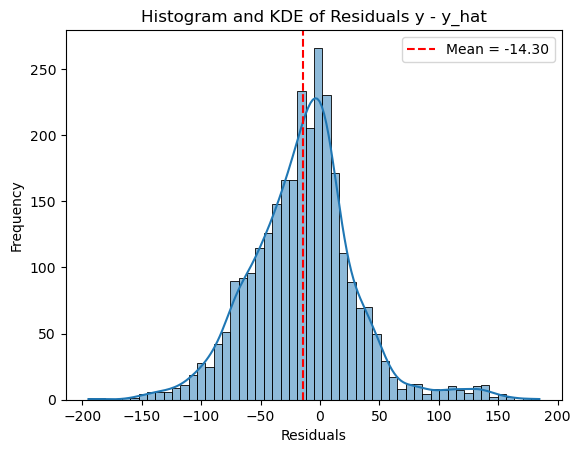

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

y_true = merged_df['price_dm']
y_pred = merged_df['mean']
residuals = y_true - y_pred

sns.histplot(residuals, kde=True)
plt.axvline(residuals.mean(), color='r', linestyle='--', label=f'Mean = {residuals.mean():.2f}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram and KDE of Residuals y - y_hat')
plt.legend()
plt.show()


In [117]:
rmse_value = rmse(y_true, y_pred)
mape_value = mape(y_true, y_pred)
smape_value = smape(y_true, y_pred)

print("RMSE:", round(rmse_value, 2))
# print("MAPE:", round(mape_value, 2))
print("SMAPE:", round(smape_value, 2))

# Mine
# RMSE: 45.99
# SMAPE: 31.02

#Baseline
# RMSE: 41.18
# SMAPE: 25.75

RMSE: 46.88
SMAPE: 31.39


In [118]:
# Choose a specific timestamp
timestamp_to_plot = '2023-04-17'

# Filter both dataframes for the chosen timestamp
ets_preds_filtered = ets_pred[timestamp_to_plot]
dm_hour_filtered = dm_hour[timestamp_to_plot]

ets_preds_filtered.head()

,mean,pi_lower,pi_upper
2023-04-17 00:00:00,105.64156,73.281116,152.099779
2023-04-17 01:00:00,101.610701,61.051931,168.679746
2023-04-17 02:00:00,102.998054,55.364682,190.886033
2023-04-17 03:00:00,121.677934,59.59988,247.348271
2023-04-17 04:00:00,164.794416,74.459066,363.274165


In [119]:
import plotly.express as px
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Line(x=ets_preds_filtered.index, y=ets_preds_filtered['mean'], name='ETS Preds'))
fig.add_trace(go.Line(x=dm_hour_filtered.index, y=dm_hour_filtered['price_dm'], name='DM Hour'))
fig.update_layout(title='ETS Preds and DM Hour at {}'.format(timestamp_to_plot))
fig.show()

